# Projeto de Estatística Computacional

Docente: Paulo Renato Alves Firmino <br>
Discente: Cauã Gomes Xavier <br>
Disciplina: Estatística Computacional <br>
Curso: Matemática Computacional <br>

# 1. Introdução

Este projeto tem como objetivo analisar um conjunto de dados sobre imóveis e desenvolver um modelo de aprendizado de máquina para prever o preço de venda de uma casa com base em suas características. As informações foram obtidas a partir de uma competição do Kaggle, uma plataforma de desafios e competições em ciência de dados. (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data). <br>
O mercado imobiliário é influenciado por diversos fatores além do número de quartos ou da presença de cozinhas. Elementos como a qualidade do material de construção, a localização e até detalhes estruturais menos óbvios podem impactar significativamente o valor final de uma propriedade. Portanto, compreender esses fatores e como eles afetam o preço das casas é essencial para compradores, vendedores e investidores tomarem decisões mais informadas. <br>
O desafio central deste projeto é prever o preço de uma casa com base em diversas variáveis, como o tamanho do terreno, a qualidade dos materiais, a condição geral da propriedade, o ano de construção, a presença de um porão e outras características estruturais.

# 2. Importações e funções

In [543]:
import pandas as pd
import seaborn as sn
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

In [544]:
def histograma(dataFrame, nomeVariavel, qntdCategorias):
    
    distribuicaoDeFrequencia(dataFrame, nomeVariavel, qntdCategorias)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    dataFrame[nomeVariavel].plot(kind='box', ax=axs[0], title='')
    sn.histplot(dataFrame[nomeVariavel], color='green', bins=qntdCategorias, ax=axs[1])
    axs[1].set_ylabel(nomeVariavel)
    plt.tight_layout()
    plt.show()

def distribuicaoDeFrequencia(dataFrame, nomeVariavel, qntdCategorias):
    
    coluna = dataFrame[nomeVariavel]
    frequencia = coluna.value_counts(bins=qntdCategorias, 
                            sort=False)
    display(pd.DataFrame(frequencia))

def graficoQualitativo(dataframe, var, ax=None):
    
     dados_qualitativa = dataframe[var].value_counts(normalize = True).reset_index(name='Frequência').rename(columns={'index':var})
     display(dados_qualitativa)
     
     if ax is None:
          fig, ax = plt.subplots(figsize=(12, 4))
     dados_grafico = dataframe[var].value_counts()
     dados_grafico.plot(kind='bar', ax=ax)
     
     plt.xlabel('Valores')
     plt.ylabel('Counts')
     plt.title(f'Gráfico da Frequência: {var}')

def graficoDiscreto(dataframe, coluna, titulo="Distribuição Discreta", xlabel="frequências", ylabel="Frequência relativa"):
   
    valores, frequencias = np.unique(dataframe[coluna].dropna(), return_counts=True) 
    probabilidades = frequencias / sum(frequencias)  
    
    plt.figure(figsize=(8, 6))
    plt.vlines(valores, 0, probabilidades, colors='blue', lw=2)  
    plt.scatter(valores, probabilidades, color='red', s=30)  
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{titulo}: {coluna}")
    plt.xticks(valores)  
    plt.grid(axis="y", linestyle="--", alpha=0.7)  

    plt.show()

def graficoQualitativoOrdinal(dataframe, coluna, xlabel="frequências", ylabel="Frequência relativa"):
    
    mapeamento = {
        "Ex": "Excellent",
        "Gd": "Good",
        "TA": "Average",
        "Fa": "Fair",
        "Po": "Poor"
    }
    
    ordem_categorias = ["Excellent", "Good", "Average", "Fair", "Poor"]
    
    dataframe[coluna] = dataframe[coluna].replace(mapeamento)
    
    dataframe[coluna] = pd.Categorical(dataframe[coluna], categories=ordem_categorias, ordered=True)
    
    dfDegrad = dataframe[coluna].value_counts(normalize=True).sort_index()
    
    qualiPlot = dfDegrad.plot(kind='bar', figsize=(12, 4), title='', fontsize=10)
    qualiPlot.set_xlabel(xlabel)
    qualiPlot.set_ylabel(ylabel)

    plt.show()

def graficoBivariado(dataframe, colunaQualitativa, colunaQuantitativa, numBins=5):

    valorMin = dataframe[colunaQuantitativa].min()
    valorMax = dataframe[colunaQuantitativa].max()
    binEdges = np.linspace(valorMin, valorMax, numBins + 1).astype(int) 

    dataframe['Prices'] = pd.cut(dataframe[colunaQuantitativa], bins=binEdges, include_lowest=True, right=False)

    tabelaContingencia = pd.crosstab(index=dataframe[colunaQualitativa], 
                                      columns=dataframe['Prices'], 
                                      normalize="index")

    tituloTabela = f"Distribuição de {colunaQuantitativa} (Agrupado) por {colunaQualitativa}"
    print("\n" + "-" * 50)
    print(f"{tituloTabela}")
    print("-" * 50)
    display(tabelaContingencia)

    plt.figure(figsize=(8,5))
    tabelaContingencia.plot(kind="bar", stacked=False, colormap="tab10", figsize=(8,5))
    
    tituloGrafico = f"{colunaQuantitativa} (Agrupado) por {colunaQualitativa}"
    plt.title(tituloGrafico, fontsize=14)
    plt.xlabel(colunaQualitativa, fontsize=12)
    plt.ylabel("Proporção", fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title=f"{colunaQuantitativa} (Agrupado)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.show()

    dataframe.drop(columns=['Prices'], inplace=True)


def medidasDispersaoPosicao(dataframe, coluna):

    media = dataframe[coluna].mean()
    moda = dataframe[coluna].mode().values
    mediana = dataframe[coluna].median()
    desvio_padrao = dataframe[coluna].std()
    variancia = dataframe[coluna].var()

    estatisticas_df = pd.DataFrame({
        "Métrica": ["Média", "Moda", "Mediana", "Desvio Padrão", "Variância"],
        "Valor": [media, moda, mediana, desvio_padrao, variancia]
    })

    from IPython.display import display
    display(estatisticas_df)

def transformarEmQualitativo(coluna):
    
    mapeamento = {
        10: "Very Excellent",
        9: "Excellent",
        8: "Very Good",
        7: "Good",
        6: "Above Average",
        5: "Average",
        4: "Below Average",
        3: "Fair",
        2: "Poor",
        1: "Very Poor"
    }
    return coluna.map(mapeamento).fillna("Desconhecido") 

def transformarAnoEmCategoria(dataframe, coluna):
   
    def categorizarAno(ano):
        if ano < 1900:
            return "Muito antiga"
        elif 1900 <= ano < 1950:
            return "Antiga"
        elif 1950 <= ano < 2000:
            return "Média idade"
        else:
            return "Nova"
    
    dataframe[coluna + 'Categoria'] = dataframe[coluna].apply(categorizarAno)

def transformarPrecoEmCategoria(dataframe, coluna):
   
    def categorizarPreco(preco):
        if preco < 214925:
            return "Baixo"
        elif 214925 <= preco < 394950:
            return "Médio baixo"
        elif 394950 <= preco < 574975:
            return "Médio alto"
        else:
            return "Alto"
    
    dataframe[coluna + 'Categoria'] = dataframe[coluna].apply(categorizarPreco)

def RedeBayesiana(dataframe):
    
    model = BayesianNetwork([
        ('YearBuiltCategoria', 'OverallQualCategoria'),
        ('YearBuiltCategoria', 'OverallCondCategoria'),
        ('OverallQualCategoria', 'SalePriceCategoria'),
        ('OverallCondCategoria', 'SalePriceCategoria'),
        ('MSZoning', 'SalePriceCategoria'),
        ('LandContour', 'SalePriceCategoria')
    ])

    
    def criar_cpd(categoria_coluna, target_coluna):
        tabela_contingencia = pd.crosstab(dataframe[categoria_coluna], dataframe[target_coluna], normalize='index')
        valores = tabela_contingencia.values
        return TabularCPD(
            variable=categoria_coluna,
            variable_card=tabela_contingencia.shape[0],  
            values=valores,
            evidence=[target_coluna],
            evidence_card=[dataframe[target_coluna].nunique()]
        )

    cpdYearBuiltOverallQual = criar_cpd('YearBuiltCategoria', 'OverallQualCategoria')

    cpdYearBuiltOverallCond = criar_cpd('YearBuiltCategoria', 'OverallCondCategoria')
    
    cpdOverallQual = criar_cpd('OverallQualCategoria', 'SalePriceCategoria')

    cpdOverallCond = criar_cpd('OverallCondCategoria', 'SalePriceCategoria')
   
    cpdMSZoning = criar_cpd('MSZoning', 'SalePriceCategoria')
   
    cpdLandContour = criar_cpd('LandContour', 'SalePriceCategoria')

    model.add_cpds(cpdYearBuiltOverallQual, cpdYearBuiltOverallCond, cpdOverallQual, cpdOverallCond, cpdMSZoning, cpdLandContour)

    return model

def plotRedeBayesiana(model):
    
    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    plt.figure(figsize=(9, 5))
    pos = nx.spring_layout(G, seed=42)  
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='gray', font_size=10, font_weight='bold', edge_color='black')

    plt.title("Grafo da Rede Bayesiana")
    plt.show()

def ajustarRedeBayesiana(dataframe, model):
   
    model.fit(dataframe, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)
    
    return model

# 3. Pré-processamento

O pré-processamento transforma dados brutos em um formato padronizado e relevante, facilitando a realização das análises, além de melhorar a qualidade dos resultados obtidos.

## 3.1. Análise descritiva dos dados

- Ao analisar as colunas abaixo, observa-se que algumas colunas apresentam um grande número de valores indefinidos (N/A). Por esse motivo, é importante removê-las da tabela, a fim de evitar interferências na extração de informações úteis dos dados. Essa abordagem contribui para uma análise mais precisa e confiável.

In [549]:
dadosTreino = pd.read_csv(filepath_or_buffer = "database/train.csv", 
                    sep=",")

dadosTreino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- Conferindo as colunas que têm mais da metade dos valores como indefinidos (N/A) e tirando elas da tabela.

In [551]:
colunasNa = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']

totalLinhasDataFrame = len(dadosTreino)
print(f"Total de linhas no DataFrame: {totalLinhasDataFrame}")

for colunaNa in colunasNa:
    quantidadeNa = dadosTreino[colunaNa].isna().sum()
    print(f"Total de valores N/A na coluna '{colunaNa}': {quantidadeNa}")
    dadosTreino.drop(columns=[colunaNa],inplace=True)

Total de linhas no DataFrame: 1460
Total de valores N/A na coluna 'Alley': 1369
Total de valores N/A na coluna 'PoolQC': 1453
Total de valores N/A na coluna 'Fence': 1179
Total de valores N/A na coluna 'MiscFeature': 1406
Total de valores N/A na coluna 'MasVnrType': 872


- A tabela abaixo representa nosso conjunto de dados. Observa-se os dados abrangem diversas informações sobre cada imóvel, incluindo planicidade do local onde a propriedade foi construida e área da varanda(em pés quadrados). Com base nessas informações, é possível obter uma visão mais ampla e detalhada dos dados, o que será explorado nas próximas etapas.

In [553]:
dadosTreino.drop(columns=["Id"],inplace=True)

dadosTreino.head(5)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


As principais **variáveis quantitativas** de interesse e como estas se relacionam com nossa variável depedente ("SalePrice"):<br>
- **YearBuilt**: Ano original da contrução. 
- **YearRemodAdd**: Ano da última remodelação. 
- **LotArea**:  Área do lote(em pés quadrados).
- **GarageArea**: Área da garagem(em pés quadrados). 
- **PoolArea**: Área da piscina(em pés quadrados).
- **Fireplaces**: Quantidade de lareiras.
- **OverallQual**: Qualidade geral do material e do acabamento(varia de 1 a 10).
- **TotalBsmtSF**: Área do porão(em pés quadrados).
- **FullBath**: Quantidade de banheiros completos.
      

é possível entender melhor a relação entre as variáveis citadas acima e a variável dependente. Para isso, utiliza-se o __Coeficiente de Correlação de Pearson__. Para isso, é necessário criar uma cópia dos dados retirando as variáveis qualitativas. <br>
A correlação de Pearson é um método estatístico que avalia a relação entre duas variáveis quantitativas. Seu valor está compreendido no intervalo de -1 a +1. <br>
Um valor igual a 0 indica ausência de associação linear entre as variáveis. Um valor maior que 0 revela que, à medida que uma variável aumenta, a outra também tende a aumentar, caracterizando uma correlação positiva. Por outro lado, um valor menor que 0 demonstra uma correlação negativa entre as variáveis, indicando que, à medida que uma variável cresce, a outra tende a diminuir. 
Apartir disso é possivel fazer a seguinte análise:

- A qualidade geral do material e do acabamento é o fator mais importante para definir o preço do imóvel.
- A área da garagem é um fator mais relevante do que o ano em que imóvel foi construido.


In [556]:
pd.set_option('display.max_rows',20)

dadosTemporário = dadosTreino.select_dtypes(include=['int64', 'float64'])

correlacaoMatriz = dadosTemporário.corr()
correlacaoMatriz["SalePrice"].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

As principais **variáveis quantitativas** de interesse e como estas se relacionam com nossa variável depedente ("SalePrice"): <br>

- **Street**: Se a rua possui asfalto
- **HouseStyle**: Estilo da casa e a quantidade de andares
- **RoofStyle**: Tipo de telhado
- **ExterQual**: Qualidade do material no exterior do imóvel
- **ExterCond**: Condição atual do material no exterior do imóvel
- **Foudation**: Material usado na construção do imóvel
- **BsmtCond**: Condição atual do porão
- **Electrical**: Sistema elétrico



### Variáveis Quantitativas

- Para criar a distribuição de frequências de uma coluna com variáveis quantitativas contínuas, é necessário definir alguns parâmetros: 

In [560]:
numeroElementos = dadosTreino['LotFrontage'].notna().sum()

print(f"Quantidade de observações: {numeroElementos}")

LotFrontageMaximo = dadosTreino['LotFrontage'].max()
print(f"Valor máximo da coluna 'LotFrontage': {LotFrontageMaximo}")

LotFrontageMinimo = dadosTreino['LotFrontage'].min()
print(f"Valor mínimo da coluna 'LotFrontage': {LotFrontageMinimo}")
  
raizQuadrada = math.sqrt(numeroElementos)  
numeroCategorias = round(raizQuadrada)

print(f"Quantidade de categorias: {numeroCategorias}")

tamanhoIntervalo = (LotFrontageMaximo - LotFrontageMinimo) / numeroCategorias

print(f"Tamanho do intervalo: {tamanhoIntervalo}")

Quantidade de observações: 1201
Valor máximo da coluna 'LotFrontage': 313.0
Valor mínimo da coluna 'LotFrontage': 21.0
Quantidade de categorias: 35
Tamanho do intervalo: 8.342857142857143


- No gráfico univariado e na distribuição de metros lineares da rua conectada a casa há uma grande concentração entre $54 \, ft$ (ou $5 \, m$)   e $62 \, ft$ (ou $5.6 \, m$), porém a maior concentração encontra-se entre $63 \, ft$ (ou $5.8 \, m$) e $71 \, ft$ (ou $6.6 \, m$).

- O gráfico em boxplot indica que as medições abaixo de $25 \, ft$ (ou $2.3 \, m$) e acima de $122 \, ft$ (ou $11.3 \, m$) já são considerados valores atípicos.

- Sendo assim, pela análise da distribuição dos gráficos e da distribuição de frequências, a maior parte dos imóveis tem entre $50 \, ft$ (ou $4.6 \, m$) e $100 \, ft$ (ou $9.3 \, m$)

,count
"(20.706999999999997, 29.343]",42
"(29.343, 37.686]",42
"(37.686, 46.029]",49
"(46.029, 54.371]",117
"(54.371, 62.714]",214
"(62.714, 71.057]",219
"(71.057, 79.4]",165
"(79.4, 87.743]",156
"(87.743, 96.086]",84
"(96.086, 104.429]",41


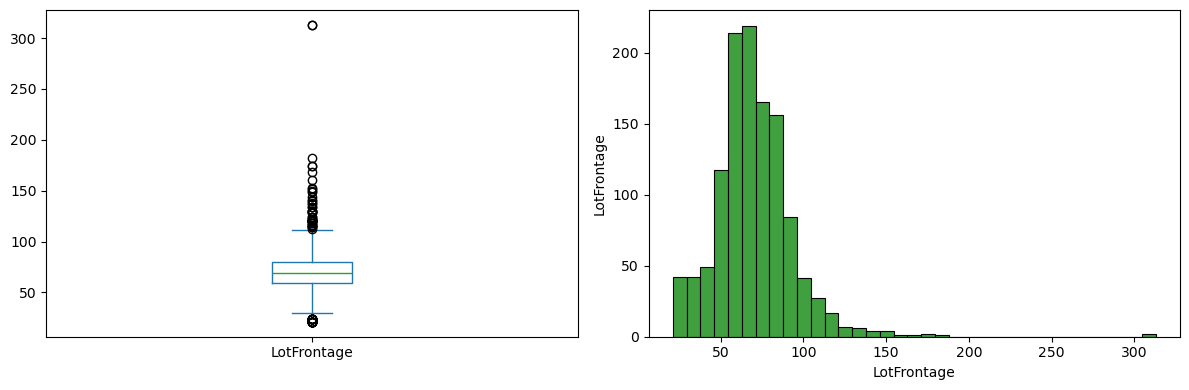

In [562]:
pd.set_option('display.max_rows', 35) 

histograma(dadosTreino, "LotFrontage", 35)

- O gráfico abaixo revela que é incomum um imóvel ter mais de duas lareiras, sugerindo que a quantidade de lareiras pode não ser um fator determinante na definição do preço da propriedade.

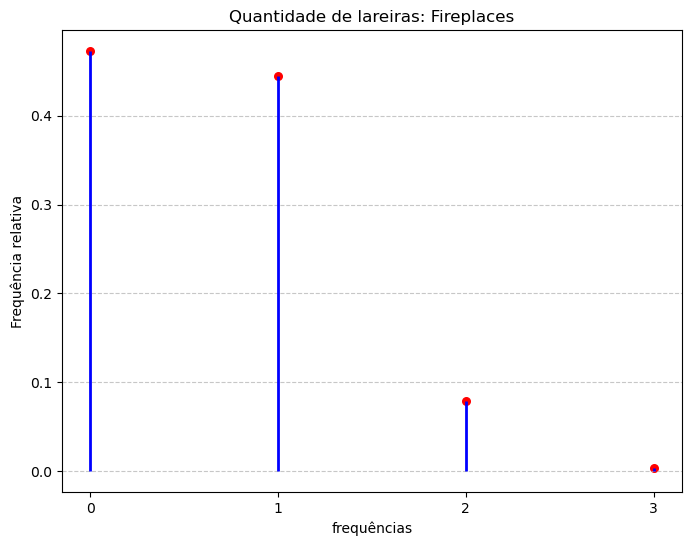

In [564]:
graficoDiscreto(dadosTreino, "Fireplaces", "Quantidade de lareiras")

### Medidas de dispersão e posição

As medidas de posição permitem estimar o valor que a variável aleatória poderá assumir, enquanto as medidas de dispersão avaliam a confiabilidade dessas estimativas. As medidas analisadas neste contexto são a moda, a média, a mediana, a variância e o desvio padrão.

A moda, a média e a mediana são medidas de posição e indicam:

- Média: obtida pela divisão da soma de todos os valores pelo número total de observações, representando o ponto de equilíbrio da amostra.
- Moda: o valor mais frequente na amostra.
- Mediana: o valor central de um conjunto de dados organizados em ordem crescente.

Já o desvio padrão e a variância são medidas de dispersão, indicando o grau de variação dos valores em relação à média, ou seja, se os dados estão mais concentrados ou dispersos.

- A mediana abaixo indica que, pelo menos a metade dos imóveis, possui uma ou nenhuma lareira. Logo, a quantidade de lareiras não deve ser muito significante para o preço da casa.

In [568]:
medidasDispersaoPosicao(dadosTreino, "Fireplaces")

,Métrica,Valor
0,Média,0.613014
1,Moda,[0]
2,Mediana,1.0
3,Desvio Padrão,0.644666
4,Variância,0.415595


- Como há uma grande variância na área dos lotes, os valores estão distantes da média, indicando uma ampla diversidade nos dados.

In [570]:
medidasDispersaoPosicao(dadosTreino, "LotArea")

,Métrica,Valor
0,Média,10516.828082
1,Moda,[7200]
2,Mediana,9478.5
3,Desvio Padrão,9981.264932
4,Variância,99625649.650342


- Como o desvio padrão da área das garagens está próximo da metade da média, isso indica que, apesar das variações, ainda há um certo padrão nos dados.

In [572]:
medidasDispersaoPosicao(dadosTreino, "GarageArea")

,Métrica,Valor
0,Média,472.980137
1,Moda,[0]
2,Mediana,480.0
3,Desvio Padrão,213.804841
4,Variância,45712.510229


- A moda da qualidade geral do material e do acabamento é 5 (mediano). Portanto, como esperado, a maioria dos imóveis não está nos extremos (excelente ou pobre).

In [574]:
medidasDispersaoPosicao(dadosTreino, "OverallQual")

,Métrica,Valor
0,Média,6.099315
1,Moda,[5]
2,Mediana,6.0
3,Desvio Padrão,1.382997
4,Variância,1.912679


- Existem poucos imóveis em que a quantidade de banheiros é 1, o que indica uma maior preferência por casas com mais banheiros.

In [576]:
medidasDispersaoPosicao(dadosTreino, "FullBath")

,Métrica,Valor
0,Média,1.565068
1,Moda,[2]
2,Mediana,2.0
3,Desvio Padrão,0.550916
4,Variância,0.303508


### Variáveis Qualitativas

- Com base no gráfico dos tipos de telhado dos imóveis apresentado abaixo, é possível observar que a maioria das propriedades possui telhados do tipo gable, representando 78% do total.

,RoofStyle,Frequência
0,Gable,0.781507
1,Hip,0.195890
2,Flat,0.008904
3,Gambrel,0.007534
4,Mansard,0.004795
5,Shed,0.001370


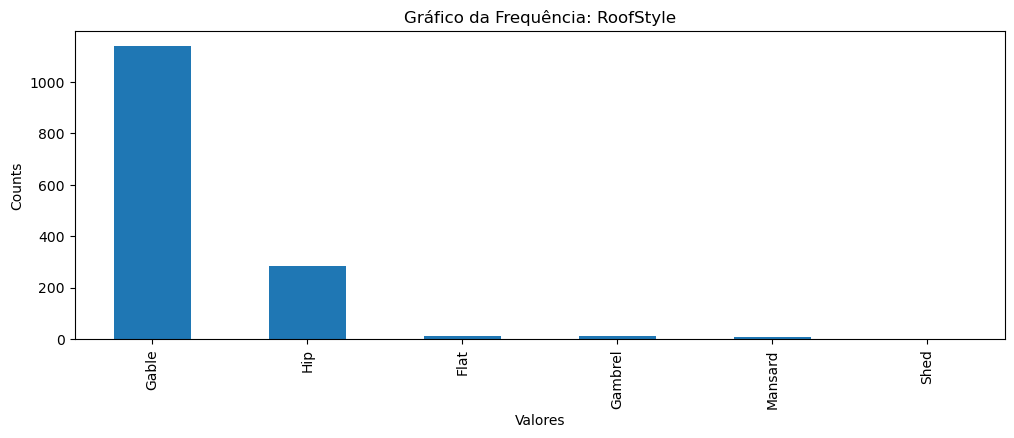

In [579]:
graficoQualitativo(dadosTreino, "RoofStyle")

- A maioria dos imóveis (aproximadamente 80%) possui a qualidade do material externo classificada como "mediana". Além disso, há uma quantidade insignificante de imóveis com qualidade "falha" ou "Pobre".

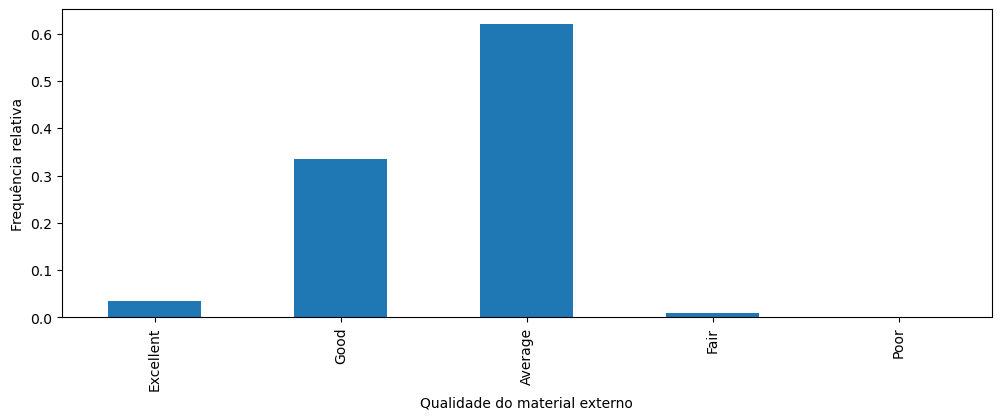

In [581]:
graficoQualitativoOrdinal(dadosTreino, "ExterQual", "Qualidade do material externo")

- Ao analisar a distribuição do preço de venda (SalePrice) por estilo de telhado (RoofStyle), é possivel observa que certos estilos apresentam uma maior concentração em faixas de preço específicas.
- O estilo Hip é o mais diversificado, abrangendo todas as faixas de preço, embora sua maior concentração esteja na faixa mais baixa (34.900 - 178.920), com mais ou menos 58%. Já o estilo Flat tem sua distribuição mais equilibrada entre as faixas inferiores, mas não aparece nas faixas mais altas.
- O estilo Shed é o mais restrito, aparecendo apenas na segunda faixa de preço (178.920 - 322.940), com 100% de sua presença ali. Isso sugere que casas com esse tipo de telhado podem ter um padrão de preço bem específico.
- Então, há uma correlação entre o tipo de telhado e a faixa de preço da casa, indicando que certos estilos são mais predominantes em determinados níveis de valor.


--------------------------------------------------
Distribuição de SalePrice (Agrupado) por RoofStyle
--------------------------------------------------


Prices,"[34900, 178920)","[178920, 322940)","[322940, 466960)","[466960, 610980)","[610980, 755000)"
RoofStyle,,,,,
Flat,0.384615,0.615385,0.000000,0.000000,0.00000
Gable,0.621930,0.347368,0.029825,0.000877,0.00000
Gambrel,0.636364,0.363636,0.000000,0.000000,0.00000
Hip,0.510490,0.332168,0.125874,0.020979,0.01049
Mansard,0.571429,0.428571,0.000000,0.000000,0.00000
Shed,0.000000,1.000000,0.000000,0.000000,0.00000


<Figure size 800x500 with 0 Axes>

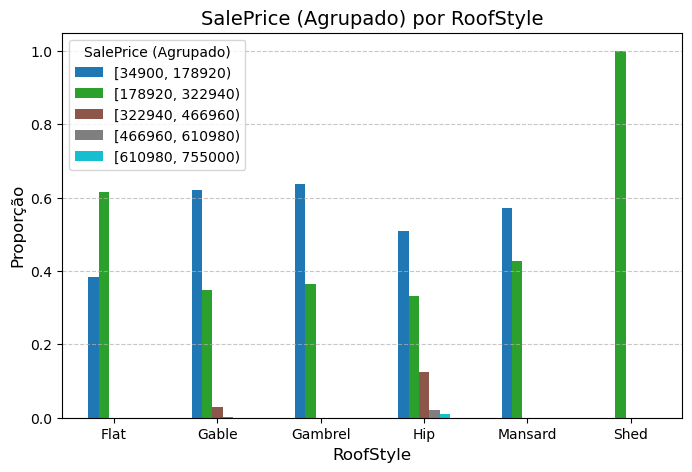

In [583]:
graficoBivariado(dadosTreino, "RoofStyle", "SalePrice")

## 3.2. Transformação de variáveis e Rede Bayesiana

- Transformando as variáveis que são Quantitativas em Qualitativas.

In [586]:
transformarAnoEmCategoria(dadosTreino, 'YearBuilt')
transformarPrecoEmCategoria(dadosTreino, 'SalePrice')

colunasParaTransformar = ['OverallQual', 'OverallCond']  

for coluna in colunasParaTransformar:
    if coluna in dadosTreino.columns:  
        dadosTreino[coluna + 'Categoria'] = transformarEmQualitativo(dadosTreino[coluna])

dadosTreino.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YearBuiltCategoria,SalePriceCategoria,OverallQualCategoria,OverallCondCategoria
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,2,2008,WD,Normal,208500,Nova,Baixo,Good,Average
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,5,2007,WD,Normal,181500,Média idade,Baixo,Above Average,Very Good
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,9,2008,WD,Normal,223500,Nova,Médio baixo,Good,Average
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,2,2006,WD,Abnorml,140000,Antiga,Baixo,Good,Average
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,12,2008,WD,Normal,250000,Nova,Médio baixo,Very Good,Average


- A variável OverallCondCategoria - Estado geral da casa atualmente - está muito próxima de SalePrice, o que sugere que esta caracteristica tem uma forte influência no preço dos Imóveis, ou seja, é um dos fatores mais relevantes a ser considerado..

- A variável MSZoning - classificação da zona onde a casa está localizada - tem uma conexão considerável com o preço da casa. A localização da propriedade, se ela está em uma área agrícola, comercial ou residencial, influencia muito seu valor.

- YearBuiltCategoria - ano de construção da casa - também mostra uma relação com o preço, mas está um pouco mais distante de SalePrice em comparação com as outras variáveis, isto é, embora o ano de construção seja importante (casas mais novas tendem a ter preços mais altos), essa variável pode ser menos decisiva do que a condição atual da casa ou a qualidade do material.

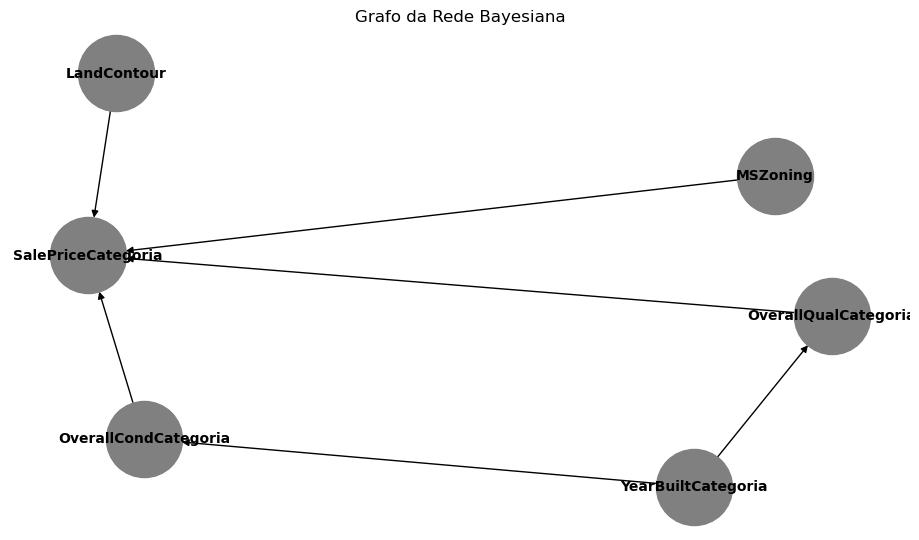

In [588]:
model = RedeBayesiana(dadosTreino)

plotRedeBayesiana(model)

- A maioria das casas são de **média idade(51.55%)** ou **novas(26.57%)**, ou seja, dentre a maior parte dos dados, os imóveis mais antigos, são de 1950.

-  Apesar de novas, a maior parte das casas têm a condição geral média, o que indica que a avaliação de condição geral não é diretamente influenciada apenas pela idade da casa.


In [590]:
modelAjustado = ajustarRedeBayesiana(dadosTreino, model)

for cpd in modelAjustado.get_cpds():
    print(cpd)

+----------------------------------+-----------+
| YearBuiltCategoria(Antiga)       | 0.207679  |
+----------------------------------+-----------+
| YearBuiltCategoria(Muito antiga) | 0.0110922 |
+----------------------------------+-----------+
| YearBuiltCategoria(Média idade)  | 0.515529  |
+----------------------------------+-----------+
| YearBuiltCategoria(Nova)         | 0.2657    |
+----------------------------------+-----------+
+--------------------------------------+-----+--------------------------+
| YearBuiltCategoria                   | ... | YearBuiltCategoria(Nova) |
+--------------------------------------+-----+--------------------------+
| OverallQualCategoria(Above Average)  | ... | 0.13391136801541426      |
+--------------------------------------+-----+--------------------------+
| OverallQualCategoria(Average)        | ... | 0.020873474630700065     |
+--------------------------------------+-----+--------------------------+
| OverallQualCategoria(Below Average)  | 

- Dentre os imóveis que foram construídos após os anos 2000, cerca de 40% possuem a qualidade geral consideradas médias. 

In [592]:
inferencia = VariableElimination(modelAjustado) 

resultadoQualYear = inferencia.query(variables=['OverallQualCategoria'], evidence={'YearBuiltCategoria': 'Nova'})
resultado = inferencia.query(variables=['SalePriceCategoria'], evidence={'OverallCondCategoria': 'Very Poor'})
print(resultado)
print(resultadoQualYear)

+---------------------------------+---------------------------+
| SalePriceCategoria              |   phi(SalePriceCategoria) |
+=================================+===========================+
| SalePriceCategoria(Alto)        |                    0.2500 |
+---------------------------------+---------------------------+
| SalePriceCategoria(Baixo)       |                    0.2501 |
+---------------------------------+---------------------------+
| SalePriceCategoria(Médio alto)  |                    0.2500 |
+---------------------------------+---------------------------+
| SalePriceCategoria(Médio baixo) |                    0.2500 |
+---------------------------------+---------------------------+
+--------------------------------------+-----------------------------+
| OverallQualCategoria                 |   phi(OverallQualCategoria) |
+======================================+=============================+
| OverallQualCategoria(Above Average)  |                      0.1339 |
+-----------